In [2]:
from google.colab import drive
drive.mount("/content/drive")

import os
import sys
sys.path.append("/content/drive/MyDrive/#fastcampus")
drive_project_root = "/content/drive/MyDrive/#fastcampus"
!pip install -r "/content/drive/MyDrive/#fastcampus/requirements.txt"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from datetime import datetime

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from omegaconf import DictConfig

import tensorflow as tf
import tensorflow_addons as tfa

import wandb

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
!nvidia-smi

Thu Dec  9 07:19:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    33W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# define qpus
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


## 데이터 및 데이터로더 정의

In [7]:

with mirrored_strategy.scope():
    # 데이터 새 정의
    fashion_mnist = tf.keras.datasets.fashion_mnist
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

    # normalization

    # turn off for efficient_net
    # x_train = x_train / 255.0
    # x_test = x_test / 255.0

    # train/val splits
    train_size = int(len(x_train) * 0.9)
    val_size = len(x_train) - train_size

    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size=1024)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(buffer_size=1024)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)
    print(len(train_dataset), len(val_dataset), len(dataset), len(test_dataset))

    # dataloader 정의
    train_batch_size = 100
    val_batch_size = 10
    test_batch_size = 100

    train_dataloader = train_dataset.batch(train_batch_size, drop_remainder=True)
    val_dataloader = val_dataset.batch(val_batch_size, drop_remainder=True)
    test_dataloader = test_dataset.batch(test_batch_size, drop_remainder=True)

sample_example = next(iter(train_dataloader))
print(sample_example)

54000 6000 60000 10000
(<tf.Tensor: shape=(100, 28, 28), dtype=uint8, numpy=
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0,

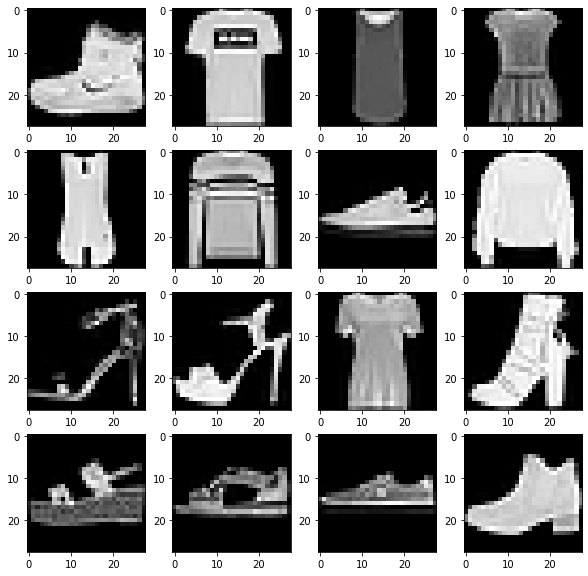

In [8]:
# plot figure
plt.figure(figsize=(10, 10))
for c in range(16):
    plt.subplot(4, 4, c+1)
    plt.imshow(x_train[c].reshape(28, 28), cmap="gray")
plt.show()

## 모델 정의

In [9]:
class MLP(tf.keras.Model):
    def __init__(self, input_dim: int, h1_dim: int, h2_dim: int, out_dim: int):
        super().__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.linear1 = tf.keras.layers.Dense(input_dim=input_dim, units=h1_dim)
        self.linear2 = tf.keras.layers.Dense(units=h2_dim)
        self.linear3 = tf.keras.layers.Dense(units=out_dim)
        self.relu = tf.nn.relu

    def call(self, input, training=False):
        x = self.flatten(input)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        out = self.linear3(x)
        out = tf.nn.softmax(out)
        return out

    def train_step(self, data):
        images, labels = data

        with tf.GradientTape() as tape:
            outputs = self(images, training=True)
            preds = tf.argmax(outputs, 1)

            loss = self.compiled_loss(
                labels, outputs
            )

        # compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # update the metrics
        self.compiled_metrics.update_state(labels, preds)

        # return a dict mapping metrics names to current vlaues
        logs = {m.name: m.result() for m in self.metrics}
        return logs


    def test_step(self, data):
        images, labels = data
        outputs = self(images, training=False)
        preds = tf.argmax(outputs, 1)
        loss = self.compiled_loss(
            labels, outputs
        )

        # update the metrics
        self.compiled_metrics.update_state(labels, preds)

        # return a dict mapping metrics names to current vlaues
        logs = {m.name: m.result() for m in self.metrics}
        return logs

In [10]:
class MLPWithDropout(tf.keras.Model):
    def __init__(self, input_dim: int, h1_dim: int, h2_dim: int, out_dim: int, dropout_prob: float):
        super().__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.linear1 = tf.keras.layers.Dense(input_dim=input_dim, units=h1_dim)
        self.linear2 = tf.keras.layers.Dense(units=h2_dim)
        self.linear3 = tf.keras.layers.Dense(units=out_dim)
        self.dropout = tf.keras.layers.Dropout(dropout_prob)
        self.relu = tf.nn.relu

    def call(self, input, training=False):
        x = self.flatten(input)
        x = self.relu(self.linear1(x))
        x = self.dropout(x, training=training)
        x = self.relu(self.linear2(x))
        x = self.dropout(x, training=training)
        out = self.linear3(x)
        out = tf.nn.softmax(out)
        return out

    def train_step(self, data):
        images, labels = data

        with tf.GradientTape() as tape:
            outputs = self(images, training=True)
            preds = tf.argmax(outputs, 1)

            loss = self.compiled_loss(
                labels, outputs
            )

        # compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # update the metrics
        self.compiled_metrics.update_state(labels, preds)

        # return a dict mapping metrics names to current vlaues
        logs = {m.name: m.result() for m in self.metrics}
        return logs


    def test_step(self, data):
        images, labels = data
        outputs = self(images, training=False)
        preds = tf.argmax(outputs, 1)
        loss = self.compiled_loss(
            labels, outputs
        )

        # update the metrics
        self.compiled_metrics.update_state(labels, preds)

        # return a dict mapping metrics names to current vlaues
        logs = {m.name: m.result() for m in self.metrics}
        return logs

In [11]:
_cnn_cfg: dict = {
    "layer_1": {
        "conv2d_filters": 32,
        "conv2d_kernel_size": [3, 3],
        "conv2d_strides": [1, 1],
        "conv2d_padding": "same",
        "maxpool2d_pool_size": [2, 2],
        "maxpool2d_strides": [2, 2],
        "maxpool2d_padding": 'valid',
    },
    "layer_2": {
        "conv2d_filters": 64,
        "conv2d_kernel_size": [3, 3],
        "conv2d_strides": [1, 1],
        "conv2d_padding": "valid",
        "maxpool2d_pool_size": [2, 2],
        "maxpool2d_strides": [1, 1],
        "maxpool2d_padding": 'valid',
    },
    "fc_1":{"units": 512},
    "fc_2":{"units": 128},
    "fc_3":{"units": 10},
    "dropout_prob": 0.25,
}
_cnn_cfg = OmegaConf.create(_cnn_cfg)
print(OmegaConf.to_yaml(_cnn_cfg))


class ConvBatchNormMaxPool(tf.keras.layers.Layer):
    def __init__(
        self,
        conv2d_filters,
        conv2d_kernel_size,
        conv2d_strides,
        conv2d_padding,
        maxpool2d_pool_size,
        maxpool2d_strides,
        maxpool2d_padding,
    ):
        super().__init__()
        self.conv2d = tf.keras.layers.Conv2D(
            filters = conv2d_filters,
            kernel_size = conv2d_kernel_size,
            strides = conv2d_strides,
            padding = conv2d_padding,
        )
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.maxpool2d = tf.keras.layers.MaxPool2D(
            pool_size = maxpool2d_pool_size,
            strides = maxpool2d_strides,
            padding = maxpool2d_padding,
        )

    def call(self, input):
        """Conv2D --> BatchNormalization -->Activation --> MaxPooling --> Dropout"""
        x = self.conv2d(input)
        x = self.batchnorm(x)
        x = tf.keras.activations.relu(x)
        out = self.maxpool2d(x)
        return out


class CNN(tf.keras.Model):
    def __init__(
        self, cfg: DictConfig = _cnn_cfg
    ):
        super().__init__()
        self.layer1 = ConvBatchNormMaxPool(
            cfg.layer_1.conv2d_filters,
            cfg.layer_1.conv2d_kernel_size,
            cfg.layer_1.conv2d_strides,
            cfg.layer_1.conv2d_padding,
            cfg.layer_1.maxpool2d_pool_size,
            cfg.layer_1.maxpool2d_strides,
            cfg.layer_1.maxpool2d_padding,
        )
        self.layer2 = ConvBatchNormMaxPool(
            cfg.layer_2.conv2d_filters,
            cfg.layer_2.conv2d_kernel_size,
            cfg.layer_2.conv2d_strides,
            cfg.layer_2.conv2d_padding,
            cfg.layer_2.maxpool2d_pool_size,
            cfg.layer_2.maxpool2d_strides,
            cfg.layer_2.maxpool2d_padding,
        )

        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(cfg.fc_1.units)
        self.fc2 = tf.keras.layers.Dense(cfg.fc_2.units)
        self.fc3 = tf.keras.layers.Dense(cfg.fc_3.units)

        self.dropout = tf.keras.layers.Dropout(cfg.dropout_prob)
        
    def call(self, input, training=False):
        input = tf.expand_dims(input, -1)  # [B X 28 X 28 X 1]
        x = self.layer1(input)
        x = self.layer2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x, training=training)
        x = self.fc2(x)
        out = self.fc3(x)
        out = tf.nn.softmax(out)
        return out

    def train_step(self, data):
        images, labels = data

        with tf.GradientTape() as tape:
            # images = [B X 28 X 28]
            outputs = self(images, training=True)
            preds = tf.argmax(outputs, 1)

            loss = self.compiled_loss(
                labels, outputs
            )

        # compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # update the metrics
        self.compiled_metrics.update_state(labels, preds)

        # return a dict mapping metrics names to current vlaues
        logs = {m.name: m.result() for m in self.metrics}
        return logs


    def test_step(self, data):
        images, labels = data
        outputs = self(images, training=False)
        preds = tf.argmax(outputs, 1)
        loss = self.compiled_loss(
            labels, outputs
        )

        # update the metrics
        self.compiled_metrics.update_state(labels, preds)

        # return a dict mapping metrics names to current vlaues
        logs = {m.name: m.result() for m in self.metrics}
        return logs

layer_1:
  conv2d_filters: 32
  conv2d_kernel_size:
  - 3
  - 3
  conv2d_strides:
  - 1
  - 1
  conv2d_padding: same
  maxpool2d_pool_size:
  - 2
  - 2
  maxpool2d_strides:
  - 2
  - 2
  maxpool2d_padding: valid
layer_2:
  conv2d_filters: 64
  conv2d_kernel_size:
  - 3
  - 3
  conv2d_strides:
  - 1
  - 1
  conv2d_padding: valid
  maxpool2d_pool_size:
  - 2
  - 2
  maxpool2d_strides:
  - 1
  - 1
  maxpool2d_padding: valid
fc_1:
  units: 512
fc_2:
  units: 128
fc_3:
  units: 10
dropout_prob: 0.25



In [12]:
_efficient_finetune_cfg: dict = {
    "efficient_net_model_name": "EfficientNetB0",
    "classes": 10,
    'efficient_net_weight_trainable': False,
    "kwargs": {
        "include_top": False,
        "weights": 'imagenet'
    }
}
_efficient_finetune_cfg = OmegaConf.create(_efficient_finetune_cfg)
print(OmegaConf.to_yaml(_efficient_finetune_cfg))

class EfficientNetFinetune(tf.keras.Model):
    def __init__(
        self, cfg: DictConfig = _efficient_finetune_cfg
    ):
        super().__init__()
        self.efficientnet = getattr(
            tf.keras.applications.efficientnet,
            cfg.efficient_net_model_name
        )(**cfg.kwargs)
        self.efficientnet.trainable = cfg.efficient_net_weight_trainable

        self.resize = tf.keras.layers.Resizing(224, 244)
        self.avgpool = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")
        self.out_dense = tf.keras.layers.Dense(units=cfg.classes)
        
        
    def call(self, input, training=False):
        input = tf.expand_dims(input, -1) # [B X 28 X 28 X 1]
        x = self.resize(input) # [B X 224 X 224 X 1]
        x = tf.stack([x, x, x], axis=-2) # [B, 224, 224, 3]
        x = self.efficientnet(x, training=training)

        # build top
        x = self.avgpool(x)
        out = self.out_dense(x)
        out = tf.nn.softmax(out)
        return out

    def train_step(self, data):
        images, labels = data

        with tf.GradientTape() as tape:
            # images = [B X 28 X 28]
            outputs = self(images, training=True)
            preds = tf.argmax(outputs, 1)

            loss = self.compiled_loss(
                labels, outputs
            )

        # compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # update the metrics
        self.compiled_metrics.update_state(labels, preds)

        # return a dict mapping metrics names to current vlaues
        logs = {m.name: m.result() for m in self.metrics}
        return logs


    def test_step(self, data):
        images, labels = data
        outputs = self(images, training=False)
        preds = tf.argmax(outputs, 1)
        loss = self.compiled_loss(
            labels, outputs
        )

        # update the metrics
        self.compiled_metrics.update_state(labels, preds)

        # return a dict mapping metrics names to current vlaues
        logs = {m.name: m.result() for m in self.metrics}
        return logs

efficient_net_model_name: EfficientNetB0
classes: 10
efficient_net_weight_trainable: false
kwargs:
  include_top: false
  weights: imagenet



In [13]:
# learning rate secheduler
class LinearWarmupLRScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self,
        lr_peak: float,
        warmup_end_steps: int,
    ):
        super().__init__()
        self.lr_peak = lr_peak
        self.warmup_end_steps = warmup_end_steps

    def __call__(self, step):
        
        step_float = tf.cast(step, tf.float32)
        warmup_end_steps = tf.cast(self.warmup_end_steps, tf.float32)
        lr_peak = tf.cast(self.lr_peak, tf.float32)

        return tf.cond(
            step_float < warmup_end_steps, # condition
            lambda: lr_peak * (tf.math.maximum(step_float, 1) / warmup_end_steps), # if condition is True
            lambda: lr_peak # else
        )


In [14]:
# 모델 정의
n_class = 10
max_epoch = 50

with mirrored_strategy.scope():
    # model = MLP(28*28*1, 128, 64, n_class)
    # model = MLPWithDropout(28*28*1, 128, 64, n_class, dropout_prob=0.3)
    # model = CNN()
    model = EfficientNetFinetune()
    model_name = type(model).__name__

    # define loss
    loss_function = tf.losses.SparseCategoricalCrossentropy()

    # define optimizer
    lr =1e-3
    # scheduler = None
    scheduler = LinearWarmupLRScheduler(lr, 1500)
    scheduler_name = type(scheduler).__name__ if scheduler is not None else "no_scheduler"
    if scheduler is None:
        scheduler = lr


    # optimizer = tf.optimizers.Adam(learning_rate=scheduler)
    # optimizer = tf.optimizers.SGD(learning_rate=scheduler)
    # optimizer = tfa.optimizers.AdamW(learning_rate=scheduler)
    optimizer = tfa.optimizers.RectifiedAdam(learning_rate=scheduler)
    # optimizer = AdamP(learning_rate=scheduler)
    optimizer_name = type(optimizer).__name__


    model.compile(
        loss=loss_function,
        optimizer=optimizer,
        metrics=[tf.keras.metrics.Accuracy()],
    )

    model.build((1, 28, 28))
model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [15]:
# define logging & callbacks
log_interval = 100
# run_name = f"{datetime.now()}-{model_name}-{optimizer_name}-optim={lr}_lr_with_{scheduler_name}"
efficient_net_weight_trainable = _efficient_finetune_cfg.efficient_net_weight_trainable
run_name = f"{datetime.now()}-{model.name}-{efficient_net_weight_trainable}"
run_dirname = "dnn-tutorial-fashion-mnist-runs-tf"
log_dir = os.path.join(drive_project_root, "runs", run_dirname, run_name)

tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir, update_freq = log_interval
)

early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=5, verbose=True)

# wandb setup
project_name = "fastcampus_fashion_mnist_tutorials_tf"
run_tags = [project_name]
wandb.init(
    project = project_name,
    name=run_name,
    tags=run_tags,
    config={
        "lr": lr,
        "model_name": model_name,
        "optimizer_name": optimizer_name,
        "scheduler_name": scheduler_name,
    },
    reinit=True,
    sync_tensorboard=True
)

wandb: Currently logged in as: lemma17 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [16]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/\#fastcampus/runs/

model.fit(
    train_dataloader,
    validation_data=val_dataloader,
    epochs=max_epoch,
    callbacks=[tb_callback, early_stop_callback]
)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 926), started 0:01:35 ago. (Use '!kill 926' to kill it.)

<IPython.core.display.Javascript object>

Epoch 1/50
540/540 [==============================] - ETA: 0s - loss: 1.7053 - accuracy: 0.4585

wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


540/540 [==============================] - 257s 454ms/step - loss: 1.7053 - accuracy: 0.4585 - val_loss: 0.7588 - val_accuracy: 0.8030
Epoch 2/50
540/540 [==============================] - 259s 480ms/step - loss: 0.5515 - accuracy: 0.8370 - val_loss: 0.4066 - val_accuracy: 0.8617
Epoch 3/50
540/540 [==============================] - 247s 457ms/step - loss: 0.3811 - accuracy: 0.8708 - val_loss: 0.3286 - val_accuracy: 0.8857
Epoch 4/50
205/540 [==========>...................] - ETA: 2:17 - loss: 0.3441 - accuracy: 0.8813

KeyboardInterrupt: ignored

## Model testing

In [ ]:
model.evaluate(test_dataloader)

100/100 [==============================] - 2s 6ms/step - loss: 0.3304 - accuracy: 0.8824


[0.3303638696670532, 0.8823999762535095]

In [ ]:
test_labels_list = []
test_preds_list = []
test_outputs_list = []

for i, (test_images, test_labels) in enumerate(tqdm(test_dataloader, position=0, leave=True, desc="testing")):
    with mirrored_strategy.scope():
        test_outputs = model(test_images)
    test_preds = tf.argmax(test_outputs, 1)

    final_outs = test_outputs.numpy()
    test_outputs_list.extend(final_outs)
    test_preds_list.extend(test_preds.numpy())
    test_labels_list.extend(test_labels.numpy())

test_preds_list = np.array(test_preds_list)
test_labels_list = np.array(test_labels_list)

test_accuracy = np.mean(test_preds_list == test_labels_list)
print(f"\nacc: {test_accuracy*100}%")

testing: 100%|██████████| 100/100 [00:00<00:00, 127.50it/s]


acc: 88.24%


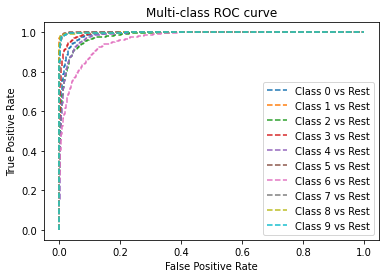

auc_score: 0.9905153


In [ ]:
# ROC Curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr = {}
tpr = {}
thresh = {}
n_class = 10

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(test_labels_list, np.array(test_outputs_list)[:, i], pos_label=i)

# plot
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], linestyle="--", label=f"Class {i} vs Rest")
plt.title("Multi-class ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.show()

auc_score = roc_auc_score(test_labels_list, test_outputs_list, multi_class="ovo", average="macro")
print(f"auc_score: {auc_score}")